# HUOPM IMPROVED: High-Utility Occupancy Pattern Mining
This notebook implements the IMPROVED HUOPM algorithm for discovering high-utility occupancy patterns in transactional databases.

In [1]:
from collections import defaultdict
import time
import random
from typing import Dict, List, Tuple, Set, Optional
import heapq  
import tracemalloc
import pandas as pd
import matplotlib.pyplot as plt
import os
from IPython.display import display
import seaborn as sns
import glob

## UtilityOccupancyList Class(Improved)
Represents the UO-list for tracking utility-occupancy stats per itemset.

In [2]:
class UtilityOccupancyList_Improved:
    """
    Hybrid UO-List optimized for Python's strengths.
    
    This class represents a utility-occupancy list for an itemset, storing transaction-level
    utility metrics and aggregate statistics. It uses a dictionary-based structure for O(1)
    lookups, making it more efficient than list-based approaches in Python.
    
    Key improvements:
    1. Uses dict for O(1) lookup (Python-optimized)
    2. Lazy conversion to list only when needed
    3. __slots__ for memory efficiency
    
    Attributes:
        itemset (tuple of str): The itemset this UO-list represents
        entries (dict): Transaction entries {tid: (uo, ruo)}
        sup (int): Support count (number of transactions containing itemset)
        sum_uo (float): Sum of utility occupancy values across all transactions
        sum_ruo (float): Sum of remaining utility occupancy values
        uo (float): Average utility occupancy (finalized)
        ruo (float): Average remaining utility occupancy (finalized)
    
    Example:
        >>> uol = UtilityOccupancyList_Improved(('a', 'b'))
        >>> uol.add_entry('T1', 0.5, 0.2)
        >>> uol.finalize_metrics()
        >>> print(uol.get_uo())
        0.5
    """
    __slots__ = ['itemset', 'entries', 'sup', 'sum_uo', 'sum_ruo', 'uo', 'ruo']
    
    def __init__(self, itemset: Tuple[str, ...]):
        """
        Initialize a utility-occupancy list for the given itemset.
        
        Args:
            itemset (tuple of str): The itemset this UO-list represents
        
        Example:
            >>> uol = UtilityOccupancyList_Improved(('a', 'c'))
        """
        self.itemset = tuple(itemset)
        self.entries: Dict[str, Tuple[float, float]] = {}  # tid -> (uo, ruo)
        self.sup: int = 0
        self.sum_uo: float = 0.0
        self.sum_ruo: float = 0.0
        self.uo: float = 0.0
        self.ruo: float = 0.0

    def add_entry(self, tid: str, uo: float, ruo: float) -> None:
        """
        Add a transaction entry to this UO-list with O(1) insertion.
        
        This method adds utility occupancy and remaining utility occupancy values
        for a specific transaction. Duplicate transaction IDs are ignored.
        
        Args:
            tid (str): Transaction identifier
            uo (float): Utility occupancy for this itemset in the transaction
            ruo (float): Remaining utility occupancy (from items appearing after this itemset)
        
        Side Effects:
            Updates sup, sum_uo, and sum_ruo if tid is new
        
        Example:
            >>> uol.add_entry('T1', 0.4, 0.3)
            >>> uol.add_entry('T2', 0.6, 0.1)
        """
        if tid not in self.entries:
            self.entries[tid] = (uo, ruo)
            self.sup += 1
            self.sum_uo += uo
            self.sum_ruo += ruo

    def finalize_metrics(self) -> None:
        """
        Calculate final average UO and RUO metrics.
        
        This method must be called after all entries have been added to compute
        the average utility occupancy and average remaining utility occupancy.
        
        Side Effects:
            Sets self.uo and self.ruo to their final average values
        
        Example:
            >>> uol.add_entry('T1', 0.5, 0.2)
            >>> uol.add_entry('T2', 0.7, 0.1)
            >>> uol.finalize_metrics()
            >>> print(uol.uo)
            0.6
        """
        if self.sup > 0:
            self.uo = self.sum_uo / self.sup
            self.ruo = self.sum_ruo / self.sup
        else:
            self.uo = 0.0
            self.ruo = 0.0
            
    def get_sup(self) -> int: 
        """
        Get the support count of this itemset.
        
        Returns:
            int: Number of transactions containing this itemset
        
        Example:
            >>> uol.get_sup()
            15
        """
        return self.sup
        
    def get_uo(self) -> float: 
        """
        Get the average utility occupancy of this itemset.
        
        Returns:
            float: Average utility occupancy ratio (0.0 to 1.0)
        
        Example:
            >>> uol.get_uo()
            0.42
        """
        return self.uo

## HUOPM Improved Mining Class
Implements the main HUOPM_Improved mining algorithm.

In [3]:
class HUOPM_Improved:
    """
    Improved High-Utility Occupancy Pattern Mining (HUOPM_Improved) Algorithm.
    
    This is an optimized implementation of HUOPM_Improved that leverages Python-specific
    optimizations for better performance compared to the baseline algorithm.
    
    Optimizations:
    1. Dictionary-based join (Python C-backend optimized)
    2. Adaptive upper bound calculation (heap vs sort)
    3. Memory-efficient data structures (__slots__)
    4. Early termination conditions
    5. Batch finalization to reduce overhead
    
    Attributes:
        min_sup_ratio (float): Minimum support threshold (alpha), range [0, 1]
        min_uo_ratio (float): Minimum utility occupancy threshold (beta), range [0, 1]
        min_sup_count (int): Minimum support count (auto-calculated)
        transactions_dict (dict): Transaction data {tid: [(item, qty), ...]}
        profit_table (dict): Profit/unit-utility per item {item: profit}
        tu_table (dict): Transaction utility table {tid: TU}
        total_order (list): List of items ordered by minimum support
        item_to_order_index (dict): Index map for each item in total_order
        huops (list): Final output, list of (itemset, support, uo) patterns
    
    Example:
        >>> miner = HUOPM_Improved(0.02, 0.3)
        >>> results = miner.fit(transactions_dict, profit_table)
        >>> print(len(results))
        47
    """
    
    def __init__(self, min_sup_ratio: float, min_uo_ratio: float):
        """
        Initialize an improved HUOPM miner with given thresholds.
        
        Args:
            min_sup_ratio (float): Minimum support ratio (alpha), value in [0, 1]
            min_uo_ratio (float): Minimum utility occupancy ratio (beta), value in [0, 1]
        
        Example:
            >>> miner = HUOPM_Improved(0.01, 0.25)
        """
        self.min_sup_ratio = min_sup_ratio
        self.min_uo_ratio = min_uo_ratio
        self.min_sup_count: int = 0
        self.transactions_dict: Dict[str, List[Tuple[str, int]]] = {}
        self.profit_table: Dict[str, float] = {}
        self.tu_table: Dict[str, float] = {}
        self.total_order: List[str] = []
        self.item_to_order_index: Dict[str, int] = {}
        self.huops: List[Tuple[Tuple[str, ...], int, float]] = []

    def fit(self, 
            transactions_dict: Dict[str, List[Tuple[str, int]]], 
            profit_table: Dict[str, float]) -> List[Tuple[Tuple[str, ...], int, float]]:
        """
        Execute the improved HUOPM algorithm on transactional data.
        
        This is the main entry point that orchestrates the three-phase mining process:
        Phase 1 (scan1), Phase 2 (scan2), and Phase 3 (recursive search).
        
        Args:
            transactions_dict (dict): Transaction DB {tid: [(item, qty), ...]}.
            profit_table (dict): Profit/unit-utility for each item {item: profit}.
        
        Returns:
            List[Tuple[Tuple[str, ...], int, float]]: List of patterns (itemset, support, uo).
        
        Side Effects:
            Populates self.huops with discovered patterns.
        
        Example:
            >>> miner = HUOPM_Improved(0.01, 0.2)
            >>> results = miner.fit(tx_db, profits)
            >>> print(results[0])
            (('a', 'c'), 15, 0.42)
        """
        self.transactions_dict = transactions_dict
        self.profit_table = profit_table
        self.min_sup_count = max(1, int(self.min_sup_ratio * len(transactions_dict)))
        
        I_star, self.total_order = self._scan1()
        self.item_to_order_index = {item: i for i, item in enumerate(self.total_order)}
        
        initial_extensions = self._scan2(I_star)
        
        self._huop_search(None, initial_extensions)
        
        return self.huops

    def _scan1(self) -> Tuple[Set[str], List[str]]:
        """
        Pass 1: First database scan to calculate transaction utilities and establish total order.
        
        This method performs the initial pass over the transaction database to:
        1. Compute the transaction utility (TU) for each transaction
        2. Count the support (frequency) of each item across all transactions
        3. Identify frequent 1-itemsets (I*) that meet minimum support threshold
        4. Create a deterministic total order of items sorted by support count and lexicographically
        
        Returns:
            Tuple[Set[str], List[str]]: A tuple containing:
                - I_star (set of str): Set of frequent items (items with support >= min_sup_count)
                - total_order (list of str): Sorted list of frequent items ordered by 
                  (support_count, item_name) for deterministic processing
        
        Side Effects:
            - Populates self.tu_table with transaction utilities {tid: TU_value}
            - Sets self.total_order as the sorted list of frequent items
        
        Example:
            >>> I_star, total_order = miner._scan1()
            >>> print(f"Frequent items: {I_star}")
            >>> print(f"Total order: {total_order}")
            {'a', 'b', 'c', 'd'}
            ['a', 'c', 'b', 'd']
        """
        item_sup = defaultdict(int)
        
        # Reset TU table to ensure no stale data
        self.tu_table = {} 

        for tid, transaction in self.transactions_dict.items():
            current_tu = 0.0
            seen_items = set()
            for item, qty in transaction:
                if item in self.profit_table:
                    # Force float calculation for consistency
                    profit = float(self.profit_table[item])
                    current_tu += float(qty) * profit
                    seen_items.add(item)
            
            self.tu_table[tid] = current_tu
            for item in seen_items:
                item_sup[item] += 1
        
        I_star = {item for item, sup in item_sup.items() if sup >= self.min_sup_count}
        
        self.total_order = sorted(list(I_star), key=lambda i: (item_sup[i], i))
        
        return I_star, self.total_order

    def _scan2(self, I_star: Set[str]) -> List[UtilityOccupancyList_Improved]:
        """
        Pass 2: Build initial UO-lists for all frequent 1-itemsets.
        
        This method performs the second database scan to construct UO-lists for each
        frequent item. For each transaction, it calculates utility occupancy (uo) and
        remaining utility occupancy (ruo) values for items based on their position
        in the total order.
        
        Args:
            I_star (set of str): Set of frequent 1-itemsets from scan1.
        
        Returns:
            List[UtilityOccupancyList_Improved]: Initial list of UO-list objects, 
                one per frequent item, ordered according to total_order.
        
        Algorithm:
            For each transaction:
                1. Filter items to only frequent ones
                2. Calculate utility for each item
                3. Sort items by total_order
                4. For each item, compute uo and ruo based on position
                5. Add entry to corresponding UO-list
        
        Example:
            >>> initial_uols = miner._scan2(I_star)
            >>> print(len(initial_uols))
            8
            >>> print(initial_uols[0].itemset)
            ('a',)
        """
        uo_lists = {item: UtilityOccupancyList_Improved((item,)) for item in I_star}
        
        for tid, transaction in self.transactions_dict.items():
            tu = self.tu_table.get(tid, 0.0)
            if tu == 0: continue
            
            # Filter and calculate utilities
            frequent_items = []
            item_utilities = {}
            
            for item, qty in transaction:
                if item in I_star and item in self.profit_table:
                    utility = qty * self.profit_table[item]
                    if utility > 0:
                        frequent_items.append(item)
                        item_utilities[item] = utility
            
            # Sort by total order
            sorted_items = sorted(
                frequent_items,
                key=lambda i: self.item_to_order_index.get(i, float('inf'))
            )
            
            # Build UO entries
            for i, item in enumerate(sorted_items):
                item_uo = item_utilities[item] / tu
                item_ruo = sum(item_utilities[sorted_items[j]] / tu 
                             for j in range(i + 1, len(sorted_items)))
                uo_lists[item].add_entry(tid, item_uo, item_ruo)
        
        # Finalize all at once
        final_extensions = []
        for item in self.total_order:
            if item in uo_lists:
                uol = uo_lists[item]
                uol.finalize_metrics()
                final_extensions.append(uol)
        
        return final_extensions

    def _huop_search(self, 
                     prefix_UOL: Optional[UtilityOccupancyList_Improved],
                     extensions_list: List[UtilityOccupancyList_Improved]) -> None:
        """
        Perform depth-first recursive search for high-utility occupancy patterns with improved pruning.
        
        This method explores the search space using pattern-growth approach with multiple
        pruning strategies to reduce computation:
        - Frequency pruning (Strategy 1)
        - Pattern acceptance checking
        - Upper-bound pruning (Strategy 2)
        - Early termination for infrequent extensions
        
        Args:
            prefix_UOL (UtilityOccupancyList_Improved | None): Current UO-list used as prefix, 
                or None for root-level search.
            extensions_list (list of UtilityOccupancyList_Improved): List of candidate extensions 
                to explore from current prefix.
        
        Returns:
            None
        
        Side Effects:
            Appends discovered HUOPs to self.huops
        
        Algorithm:
            For each extension Xa:
                1. Check support threshold (frequency pruning)
                2. Check if Xa is a HUOP (meets min_uo_ratio)
                3. Calculate upper bound φ̂(Xa)
                4. If φ̂(Xa) >= min_uo_ratio, generate further extensions
                5. Recursively search extensions
        
        Example:
            >>> miner._huop_search(None, initial_uols)
            # Populates self.huops with patterns
        """
        for i in range(len(extensions_list)):
            Xa_UOL = extensions_list[i]
            
            # Early support check
            if Xa_UOL.get_sup() < self.min_sup_count:
                continue
            
            # Check if HUOP
            if Xa_UOL.get_uo() >= self.min_uo_ratio:
                self.huops.append((Xa_UOL.itemset, Xa_UOL.get_sup(), Xa_UOL.get_uo()))
            
            # Calculate upper bound with adaptive strategy
            phi_hat_Xa = self._calculate_upper_bound_adaptive(Xa_UOL)
            
            if phi_hat_Xa >= self.min_uo_ratio:
                extenOfXa = []
                for j in range(i + 1, len(extensions_list)):
                    Xb_UOL = extensions_list[j]
                    Xab_UOL = self._construct_fast(prefix_UOL, Xa_UOL, Xb_UOL)
                    if Xab_UOL.get_sup() >= self.min_sup_count:
                        extenOfXa.append(Xab_UOL)
                
                if extenOfXa:
                    self._huop_search(Xa_UOL, extenOfXa)

    def _construct_fast(self,
                       X_UOL: Optional[UtilityOccupancyList_Improved],
                       Xa_UOL: UtilityOccupancyList_Improved,
                       Xb_UOL: UtilityOccupancyList_Improved) -> UtilityOccupancyList_Improved:
        """
        Construct a UO-list for the joined itemset (Xa ∪ {b}) using optimized set intersection.
        
        This optimized version uses Python's C-optimized dictionary key intersection,
        which is faster than merge-join approaches for string TIDs because:
        1. Set operations on dict keys are implemented in C
        2. No sorting overhead required
        3. Cache-friendly for small-medium datasets
        
        Args:
            X_UOL (UtilityOccupancyList_Improved | None): UO-list of the prefix (for k>2), 
                or None for k=2 case.
            Xa_UOL (UtilityOccupancyList_Improved): UO-list for left itemset.
            Xb_UOL (UtilityOccupancyList_Improved): UO-list for right itemset.
        
        Returns:
            UtilityOccupancyList_Improved: The constructed UO-list for the joined itemset Xab.
        
        Algorithm:
            1. Find common transactions using fast set intersection
            2. For each common transaction:
               - If k=2: uo(Xab) = uo(Xa) + uo(Xb)
               - If k>2: uo(Xab) = uo(Xa) + uo(Xb) - uo(X)
               - ruo(Xab) = ruo(Xb)
            3. Finalize metrics for Xab
        
        Example:
            >>> Xab_UOL = miner._construct_fast(X_UOL, Xa_UOL, Xb_UOL)
            >>> print(Xab_UOL.itemset)
            ('a', 'c', 'd')
        """
        Xab_itemset = Xa_UOL.itemset + (Xb_UOL.itemset[-1],)
        Xab_UOL = UtilityOccupancyList_Improved(Xab_itemset)
        
        # Fast set intersection
        common_tids = Xa_UOL.entries.keys() & Xb_UOL.entries.keys()
        
        Xa_entries = Xa_UOL.entries
        Xb_entries = Xb_UOL.entries
        X_entries = X_UOL.entries if X_UOL else None
        
        for tid in common_tids:
            uo_a, ruo_a = Xa_entries[tid]
            uo_b, ruo_b = Xb_entries[tid]
            new_ruo = ruo_b
            
            if X_entries is None:
                new_uo = uo_a + uo_b
            else:
                uo_x = X_entries.get(tid, (0.0, 0.0))[0]
                new_uo = uo_a + uo_b - uo_x
            
            Xab_UOL.add_entry(tid, new_uo, new_ruo)
        
        Xab_UOL.finalize_metrics()
        return Xab_UOL

    def _calculate_upper_bound_adaptive(self, 
                                       uol: UtilityOccupancyList_Improved) -> float:
        """
        Compute utility occupancy upper bound (φ̂) using adaptive strategy.
        
        This method adaptively chooses between heap-based and sort-based approaches
        based on the ratio k/N, where k is min_sup_count and N is the number of entries:
        - Heap-based (O(N log k)): Best for k < 0.2*N (sparse patterns, small k)
        - Sort-based (O(N log N)): Best for k >= 0.2*N (dense patterns, large k)
        
        The upper bound φ̂(X) is calculated as the average of the top-k highest
        (uo + ruo) values, which provides an optimistic estimate for pruning.
        
        Args:
            uol (UtilityOccupancyList_Improved): The UO-list for which to calculate the bound.
        
        Returns:
            float: The upper bound φ̂, used to prune the search space. Returns 0.0 if 
                insufficient transactions.
        
        Example:
            >>> phi_hat = miner._calculate_upper_bound_adaptive(uol)
            >>> print(phi_hat)
            0.58
        """
        V_occu = [uo + ruo for uo, ruo in uol.entries.values()]
        k = self.min_sup_count
        
        if len(V_occu) < k:
            return 0.0
        
        # Adaptive threshold: use heap for sparse, sort for dense
        if k < len(V_occu) * 0.2:
            # Heap-based (O(N log k))
            top_k = heapq.nlargest(k, V_occu)
            return sum(top_k) / k
        else:
            # Sort-based (O(N log N), but Timsort is faster for large k)
            V_occu.sort(reverse=True)
            return sum(V_occu[:k]) / k

    def _calculate_upper_bound_heap(self, 
                                   uol: UtilityOccupancyList_Improved) -> float:
        """
        Compute utility occupancy upper bound (φ̂) using min-heap approach.
        
        This method maintains a min-heap of size k containing the largest k values.
        Time complexity: O(N log k), space complexity: O(k).
        
        Args:
            uol (UtilityOccupancyList_Improved): The UO-list for which to calculate the bound.
        
        Returns:
            float: The upper bound φ̂. Returns 0.0 if insufficient transactions.
        
        Algorithm:
            1. Build min-heap of first k values
            2. For remaining values, if larger than heap min, replace it
            3. Sum all values in heap and divide by k
        
        Example:
            >>> phi_hat = miner._calculate_upper_bound_heap(uol)
            >>> print(phi_hat)
            0.56
        """
        V_occu = [uo + ruo for uo, ruo in uol.entries.values()]
        k = self.min_sup_count
        
        if len(V_occu) < k:
            return 0.0
        
        min_heap = []
        for val in V_occu:
            if len(min_heap) < k:
                heapq.heappush(min_heap, val)
            elif val > min_heap[0]:
                heapq.heapreplace(min_heap, val)
        
        return sum(min_heap) / k

    def _calculate_upper_bound_sort(self, 
                                   uol: UtilityOccupancyList_Improved) -> float:
        """
        Compute utility occupancy upper bound (φ̂) using full-sort approach.
        
        This method sorts all (uo + ruo) values in descending order and takes
        the average of the top k values. Time complexity: O(N log N).
        
        Args:
            uol (UtilityOccupancyList_Improved): The UO-list for which to calculate the bound.
        
        Returns:
            float: The upper bound φ̂. Returns 0.0 if insufficient transactions.
        
        Algorithm:
            1. Calculate all (uo + ruo) values
            2. Sort in descending order
            3. Sum top k values and divide by k
        
        Example:
            >>> phi_hat = miner._calculate_upper_bound_sort(uol)
            >>> print(phi_hat)
            0.56
        """
        V_occu = [uo + ruo for uo, ruo in uol.entries.values()]
        k = self.min_sup_count
        
        if len(V_occu) < k:
            return 0.0
        
        V_occu.sort(reverse=True)
        return sum(V_occu[:k]) / k

## Helper Functions
Functions for data loading, profit table generation

In [4]:
def parse_dataset(filepath: str) -> Tuple[List[List[str]], Set[str]]:
    """
    Parse space-delimited transactional dataset file into item-only transactions.
    
    PURPOSE:
    Read standard sparse transaction format (one transaction per line, 
    space-separated item IDs) used by most utility mining algorithms.
    
    INPUT FORMAT:
    ```
    A B C
    B D
    A C
    ```
    
    OUTPUT FORMAT:
    ```
    transactions: [['A','B','C'], ['B','D'], ['A','C']]
    all_items: {'A','B','C','D'}
    ```
    
    ERROR HANDLING:
    - FileNotFoundError → empty lists/sets with error message
    - Malformed lines (empty after strip) → skipped silently
    - Other IO errors → empty lists/sets with error message
    
    PARAMETERS:
    filepath : str
        Path to dataset file
        
    RETURNS:
    Tuple[List[List[str]], Set[str]]:
        - transactions: List of transaction lists (items as strings)
        - all_items: Set of all unique items across dataset
    """
    """Parse a space-delimited transactional dataset file."""
    transactions = []
    all_items = set()
    
    print(f"Parsing dataset: {filepath}")
    
    try:
        with open(filepath, 'r') as f:
            for line_num, line in enumerate(f, 1):
                items = line.strip().split()
                if items:
                    transactions.append(items)
                    all_items.update(items)
        
        print(f"  Parsed {len(transactions)} transactions, {len(all_items)} unique items.")
        
    except FileNotFoundError:
        print(f"Error: File not found at {filepath}")
        return [], set()
    except Exception as e:
        print(f"Error reading file: {e}")
        return [], set()
    
    return transactions, all_items



def generate_profit_table(all_items: Set[str], 
                          min_profit: float = 0.1,
                          max_profit: float = 10.0) -> Dict[str, float]:
    """
    Generate synthetic external utility (profit) table for utility mining.
    
    PURPOSE:
    Assign random profit-per-unit values to items for experimentation.
    Simulates real-world scenario where items have different profit margins.
    
    DISTRIBUTION:
    Uniform random [min_profit, max_profit], rounded to 2 decimal places.
    
    EXAMPLE:
    Input: {'A','B','C'}
    Output: {'A': 3.45, 'B': 7.82, 'C': 1.23}
    
    PARAMETERS:
    all_items : Set[str]
        All unique items requiring profit values
    min_profit : float = 0.1
        Minimum profit per unit
    max_profit : float = 10.0  
        Maximum profit per unit
        
    RETURNS:
    Dict[str, float]: {item → profit_per_unit}
    """
    """Generate a dictionary assigning random profit values to each item."""
    print(f"Generating profit table for {len(all_items)} items...")
    
    profit_table = {}
    sorted_items = sorted(list(all_items))
    for item in sorted_items:
        profit_table[item] = round(random.uniform(min_profit, max_profit), 2)
    
    return profit_table



def simulate_quantitative_data(
    base_transactions: List[List[str]],
    min_quantity: int = 1,
    max_quantity: int = 5
) -> Tuple[Dict[str, List[Tuple[str, int]]], Dict[str, float]]:
    """
    Convert sparse transactions to quantitative format for HUOPM_Improved.
    
    PURPOSE:
    Transform item-only transactions into HUOPM-compatible format by:
    1. Assigning TID strings (T1, T2, ...)
    2. Adding random quantities per item [min_quantity, max_quantity]
    3. Generating matching profit table
    
    INPUT FORMAT:
    [['A','B'], ['B','C','D']]
    
    OUTPUT FORMAT:
    transactions_dict: {
        'T1': [('A', 3), ('B', 1)], 
        'T2': [('B', 4), ('C', 2), ('D', 5)]
    }
    profit_table: {'A': 5.2, 'B': 3.1, ...}
    
    PARAMETERS:
    base_transactions : List[List[str]]
        Sparse transactions (items only)
    min_quantity : int = 1
        Minimum quantity per item occurrence
    max_quantity : int = 5
        Maximum quantity per item occurrence
        
    RETURNS:
    Tuple[Dict[str, List[Tuple[str,int]]], Dict[str,float]]:
        - transactions_dict: {TID → [(item, quantity), ...]}
        - profit_table: {item → profit_per_unit}
    """
    """Simulate quantitative transaction data by assigning random quantities to items."""
    all_items = set()
    for tx in base_transactions:
        all_items.update(tx)
    
    profit_table = generate_profit_table(all_items)
    
    print(f"Simulating quantitative data for {len(base_transactions)} transactions...")
    
    transactions_dict = {}
    for i, tx in enumerate(base_transactions):
        tid = f"T{i+1}"
        quantitative_tx = []
        
        for item in tx:
            quantity = random.randint(min_quantity, max_quantity)
            quantitative_tx.append((item, quantity))
        
        transactions_dict[tid] = quantitative_tx
    
    return transactions_dict, profit_table


print("Dataset parsing functions loaded!")

Dataset parsing functions loaded!


## Experiment: Running HUOPM_Improved Miner
Below, data is loaded, parameters set, mining is executed, and results are saved.

In [5]:
BASE_OUTPUT_DIR = "huopm_improved_results"
os.makedirs(BASE_OUTPUT_DIR, exist_ok=True)

def run_dataset_experiment(dataset_name, filepath, alpha_tests, beta_tests):
    """
    Runs experiments specifically for the HUOPM_Improved class defined in this notebook.
    
    Args:
        dataset_name (str): Name of the dataset (e.g., "Retail")
        filepath (str): Path to the .txt file
        alpha_tests (list): List of support thresholds
        beta_tests (list): List of utility occupancy thresholds
    """
    # CONFIGURATION
    algo_label = "HUOPM_Improved" 
    AlgorithmClass = HUOPM_Improved

    print(f"START RUNNING: {dataset_name} using {algo_label}")
    
    #Create Sub-directory: huopm_results/Retail/HUOPM_Improved/
    dataset_dir = os.path.join(BASE_OUTPUT_DIR, dataset_name, algo_label)
    os.makedirs(dataset_dir, exist_ok=True)
    print(f"Output Directory: {dataset_dir}")

    # 2. Parse & Simulate Data
    try:
        print(f"Loading data from: {filepath}")
        random.seed(42)
        base_transactions, all_items = parse_dataset(filepath)
        
        if not base_transactions:
            print(" No transactions found. Check filepath.")
            return

        print(f"   Parsed {len(base_transactions)} transactions.")
        
        print("   Generating synthetic utility values...")
        transactions_dict, profit_table = simulate_quantitative_data(base_transactions)
        
    except Exception as e:
        print(f" CRITICAL ERROR loading {dataset_name}: {e}")
        return

    summary_list = []

    # 3. Main Loop
    for alpha in alpha_tests:
        for beta in beta_tests:
            print(f"\nRunning: Alpha={alpha}, Beta={beta} ...")
            
            # Initialize the specific HUOPM_Improved class
            miner = AlgorithmClass(min_sup_ratio=alpha, min_uo_ratio=beta)
            
            tracemalloc.start()
            start_time = time.time()
            
            try:
                # EXECUTE
                huops_results = miner.fit(transactions_dict, profit_table)
                
                # METRICS
                end_time = time.time()
                current_mem, peak_mem = tracemalloc.get_traced_memory()
                tracemalloc.stop()
                
                runtime = end_time - start_time
                peak_memory_mb = peak_mem / (1024 * 1024)
                num_patterns = len(huops_results)
                
                print(f" DONE in {runtime:.4f}s | Mem: {peak_memory_mb:.2f}MB | Patterns: {num_patterns}")

                # 4. Save Pattern File
                pattern_filename = f"{dataset_name}_{algo_label}_a{alpha}_b{beta}.txt"
                pattern_path = os.path.join(dataset_dir, pattern_filename)
                
                with open(pattern_path, "w", encoding='utf-8') as f:
                    # Write Header exactly as requested
                    f.write(f"# Dataset: {dataset_name}\n")
                    f.write(f"# Algorithm: {algo_label}\n")  # Algorithm Name
                    f.write(f"# Params: Alpha={alpha}, Beta={beta}\n")
                    f.write(f"# Runtime: {runtime:.6f}s\n")
                    f.write(f"# Peak Memory: {peak_memory_mb:.6f} MB\n")
                    f.write(f"# Count: {num_patterns}\n")
                    
                    # Write Patterns
                    for pat in huops_results:
                        f.write(f"{pat}\n") 
                
                # Add to summary list
                summary_list.append({
                    'dataset': dataset_name,
                    'algorithm': algo_label,
                    'alpha': alpha,
                    'beta': beta,
                    'runtime_sec': runtime,
                    'peak_memory_mb': peak_memory_mb,
                    'patterns_found': num_patterns,
                    'pattern_file_path': pattern_path
                })

            except Exception as e:
                print(f"ERROR during mining: {e}")
                tracemalloc.stop()

    # 5. Save Dataset Summary CSV
    if summary_list:
        df_final = pd.DataFrame(summary_list)
        csv_path = os.path.join(dataset_dir, f"{dataset_name}_{algo_label}_summary.csv")
        df_final.to_csv(csv_path, index=False)
        print(f"\nExperiment Finished. Summary saved to: {csv_path}")
        display(df_final)
    else:
        print(f"\nExperiment Finished. No results to save.")

In [6]:
# Small test with toy data
print("SMALL TEST: Verifying HUOPM implementation")

toy_transactions = {
    'T1': [('A', 2), ('B', 6), ('C', 1)],
    'T2': [('A', 1), ('D', 3), ('G', 2)],
    'T3': [('B', 1), ('D', 2), ('G', 3)],
    'T4': [('A', 1), ('C', 5), ('D', 2)],
    'T5': [('B', 4), ('D', 1), ('F', 1)],
}

toy_profits = {
    'A': 3.0, 'B': 1.0, 'C': 1.0,
    'D': 5.0, 'F': 3.0, 'G': 2.0,
}

miner = HUOPM_Improved(min_sup_ratio=0.4, min_uo_ratio=0.3)
results = miner.fit(toy_transactions, toy_profits)

print("\nResults:")
for pattern, support, uo in results[:10]:
    print(f"  {pattern}: sup={support}, uo={uo:.4f}")

print("\nSmall test completed successfully!")

SMALL TEST: Verifying HUOPM implementation

Results:
  ('C', 'A'): sup=2, uo=0.4915
  ('G', 'D'): sup=2, uo=0.9024
  ('A', 'D'): sup=2, uo=0.7702
  ('B', 'D'): sup=2, uo=0.6985
  ('D',): sup=4, uo=0.5606

Small test completed successfully!


In [7]:
dataset_name = "Retail"
filepath = "datasets/retail.txt" 

# Experiment Parameters
alphas = [0.002,0.001,0.0008] 
betas = [0.2,0.3]

# Run
run_dataset_experiment(dataset_name, filepath, alphas, betas)

START RUNNING: Retail using HUOPM_Improved
Output Directory: huopm_improved_results/Retail/HUOPM_Improved
Loading data from: datasets/retail.txt
Parsing dataset: datasets/retail.txt
  Parsed 88162 transactions, 16470 unique items.
   Parsed 88162 transactions.
   Generating synthetic utility values...
Generating profit table for 16470 items...
Simulating quantitative data for 88162 transactions...

Running: Alpha=0.002, Beta=0.2 ...
 DONE in 16.9570s | Mem: 76.33MB | Patterns: 299

Running: Alpha=0.002, Beta=0.3 ...
 DONE in 16.1331s | Mem: 76.13MB | Patterns: 43

Running: Alpha=0.001, Beta=0.2 ...
 DONE in 36.6197s | Mem: 94.61MB | Patterns: 751

Running: Alpha=0.001, Beta=0.3 ...
 DONE in 38.1658s | Mem: 94.49MB | Patterns: 111

Running: Alpha=0.0008, Beta=0.2 ...
 DONE in 52.0647s | Mem: 99.90MB | Patterns: 1031

Running: Alpha=0.0008, Beta=0.3 ...
 DONE in 168.2525s | Mem: 99.83MB | Patterns: 143

Experiment Finished. Summary saved to: huopm_improved_results/Retail/HUOPM_Improved/R

,dataset,algorithm,alpha,beta,runtime_sec,peak_memory_mb,patterns_found,pattern_file_path
0,Retail,HUOPM_Improved,0.0020,0.2,16.957012,76.330786,299,huopm_improved_results/Retail/HUOPM_Improved/R...
1,Retail,HUOPM_Improved,0.0020,0.3,16.133053,76.129982,43,huopm_improved_results/Retail/HUOPM_Improved/R...
2,Retail,HUOPM_Improved,0.0010,0.2,36.619733,94.606518,751,huopm_improved_results/Retail/HUOPM_Improved/R...
3,Retail,HUOPM_Improved,0.0010,0.3,38.165785,94.487215,111,huopm_improved_results/Retail/HUOPM_Improved/R...
4,Retail,HUOPM_Improved,0.0008,0.2,52.064723,99.897322,1031,huopm_improved_results/Retail/HUOPM_Improved/R...
5,Retail,HUOPM_Improved,0.0008,0.3,168.252478,99.826687,143,huopm_improved_results/Retail/HUOPM_Improved/R...


In [8]:
dataset_name = "Foodmart"
filepath = "datasets/foodmartFIM.txt" 

alphas = [0.005,0.001,0.0005] 
betas = [0.2, 0.3]

run_dataset_experiment(dataset_name, filepath, alphas, betas)

START RUNNING: Foodmart using HUOPM_Improved
Output Directory: huopm_improved_results/Foodmart/HUOPM_Improved
Loading data from: datasets/foodmartFIM.txt
Parsing dataset: datasets/foodmartFIM.txt
  Parsed 4141 transactions, 1559 unique items.
   Parsed 4141 transactions.
   Generating synthetic utility values...
Generating profit table for 1559 items...
Simulating quantitative data for 4141 transactions...

Running: Alpha=0.005, Beta=0.2 ...
 DONE in 0.0589s | Mem: 0.26MB | Patterns: 12

Running: Alpha=0.005, Beta=0.3 ...
 DONE in 0.0616s | Mem: 0.26MB | Patterns: 9

Running: Alpha=0.001, Beta=0.2 ...
 DONE in 6.0692s | Mem: 3.04MB | Patterns: 933

Running: Alpha=0.001, Beta=0.3 ...
 DONE in 5.7078s | Mem: 2.98MB | Patterns: 399

Running: Alpha=0.0005, Beta=0.2 ...
 DONE in 5.9993s | Mem: 3.23MB | Patterns: 3302

Running: Alpha=0.0005, Beta=0.3 ...
 DONE in 6.1546s | Mem: 3.19MB | Patterns: 2280

Experiment Finished. Summary saved to: huopm_improved_results/Foodmart/HUOPM_Improved/Food

,dataset,algorithm,alpha,beta,runtime_sec,peak_memory_mb,patterns_found,pattern_file_path
0,Foodmart,HUOPM_Improved,0.0050,0.2,0.058941,0.261421,12,huopm_improved_results/Foodmart/HUOPM_Improved...
1,Foodmart,HUOPM_Improved,0.0050,0.3,0.061602,0.259155,9,huopm_improved_results/Foodmart/HUOPM_Improved...
2,Foodmart,HUOPM_Improved,0.0010,0.2,6.069201,3.039323,933,huopm_improved_results/Foodmart/HUOPM_Improved...
3,Foodmart,HUOPM_Improved,0.0010,0.3,5.707804,2.975280,399,huopm_improved_results/Foodmart/HUOPM_Improved...
4,Foodmart,HUOPM_Improved,0.0005,0.2,5.999291,3.233353,3302,huopm_improved_results/Foodmart/HUOPM_Improved...
5,Foodmart,HUOPM_Improved,0.0005,0.3,6.154604,3.192886,2280,huopm_improved_results/Foodmart/HUOPM_Improved...


In [9]:
dataset_name = "Mushroom"
filepath = "datasets/mushrooms.txt"

alphas = [0.4, 0.3, 0.2]  
betas = [0.4, 0.5]        

run_dataset_experiment(dataset_name, filepath, alphas, betas)

START RUNNING: Mushroom using HUOPM_Improved
Output Directory: huopm_improved_results/Mushroom/HUOPM_Improved
Loading data from: datasets/mushrooms.txt
Parsing dataset: datasets/mushrooms.txt
  Parsed 8416 transactions, 119 unique items.
   Parsed 8416 transactions.
   Generating synthetic utility values...
Generating profit table for 119 items...
Simulating quantitative data for 8416 transactions...

Running: Alpha=0.4, Beta=0.4 ...
 DONE in 2.8872s | Mem: 17.62MB | Patterns: 0

Running: Alpha=0.4, Beta=0.5 ...
 DONE in 2.2708s | Mem: 16.61MB | Patterns: 0

Running: Alpha=0.3, Beta=0.4 ...
 DONE in 5.4680s | Mem: 28.03MB | Patterns: 2

Running: Alpha=0.3, Beta=0.5 ...
 DONE in 3.4401s | Mem: 23.60MB | Patterns: 0

Running: Alpha=0.2, Beta=0.4 ...
 DONE in 320.8784s | Mem: 41.57MB | Patterns: 13147

Running: Alpha=0.2, Beta=0.5 ...
 DONE in 6492.9497s | Mem: 40.60MB | Patterns: 2608

Experiment Finished. Summary saved to: huopm_improved_results/Mushroom/HUOPM_Improved/Mushroom_HUOPM_Im

,dataset,algorithm,alpha,beta,runtime_sec,peak_memory_mb,patterns_found,pattern_file_path
0,Mushroom,HUOPM_Improved,0.4,0.4,2.887239,17.623716,0,huopm_improved_results/Mushroom/HUOPM_Improved...
1,Mushroom,HUOPM_Improved,0.4,0.5,2.270769,16.608201,0,huopm_improved_results/Mushroom/HUOPM_Improved...
2,Mushroom,HUOPM_Improved,0.3,0.4,5.467988,28.025894,2,huopm_improved_results/Mushroom/HUOPM_Improved...
3,Mushroom,HUOPM_Improved,0.3,0.5,3.440098,23.599496,0,huopm_improved_results/Mushroom/HUOPM_Improved...
4,Mushroom,HUOPM_Improved,0.2,0.4,320.878407,41.573303,13147,huopm_improved_results/Mushroom/HUOPM_Improved...
5,Mushroom,HUOPM_Improved,0.2,0.5,6492.949653,40.600877,2608,huopm_improved_results/Mushroom/HUOPM_Improved...


In [10]:
dataset_name = "Chainstore"
filepath = "datasets/chainstore.txt"

alphas = [0.01] 
betas = [0.2]

run_dataset_experiment(dataset_name, filepath, alphas, betas)

START RUNNING: Chainstore using HUOPM_Improved
Output Directory: huopm_improved_results/Chainstore/HUOPM_Improved
Loading data from: datasets/chainstore.txt
Parsing dataset: datasets/chainstore.txt


  Parsed 1112949 transactions, 910126 unique items.
   Parsed 1112949 transactions.
   Generating synthetic utility values...
Generating profit table for 910126 items...
Simulating quantitative data for 1112949 transactions...

Running: Alpha=0.01, Beta=0.2 ...
 DONE in 41272.3220s | Mem: 734.95MB | Patterns: 1

Experiment Finished. Summary saved to: huopm_improved_results/Chainstore/HUOPM_Improved/Chainstore_HUOPM_Improved_summary.csv


,dataset,algorithm,alpha,beta,runtime_sec,peak_memory_mb,patterns_found,pattern_file_path
0,Chainstore,HUOPM_Improved,0.01,0.2,41272.322048,734.949463,1,huopm_improved_results/Chainstore/HUOPM_Improv...


Loading: huopm_improved_results/Foodmart/HUOPM_Improved/Foodmart_HUOPM_Improved_summary.csv
Loading: huopm_improved_results/Mushroom/HUOPM_Improved/Mushroom_HUOPM_Improved_summary.csv
Loading: huopm_improved_results/Retail/HUOPM_Improved/Retail_HUOPM_Improved_summary.csv
Loading: huopm_improved_results/Chainstore/HUOPM_Improved/Chainstore_HUOPM_Improved_summary.csv

Data loaded successfully. Columns: ['dataset', 'algorithm', 'alpha', 'beta', 'runtime_sec', 'peak_memory_mb', 'patterns_found', 'pattern_file_path']
Plotting details for: Foodmart
Saved to huopm_improved_plots/Foodmart_analysis.png
Plotting details for: Mushroom
Saved to huopm_improved_plots/Mushroom_analysis.png
Plotting details for: Retail
Saved to huopm_improved_plots/Retail_analysis.png
Plotting details for: Chainstore
Saved to huopm_improved_plots/Chainstore_analysis.png
Plotting global comparison...


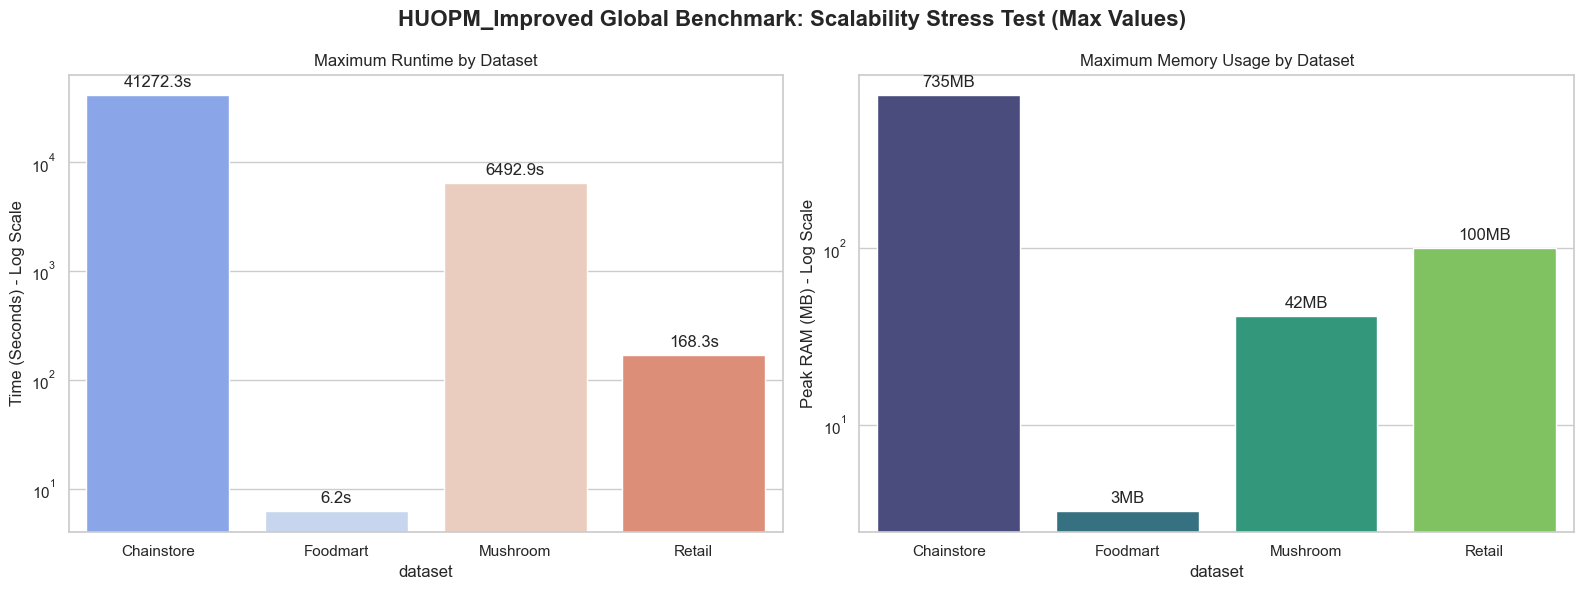

Saved to huopm_improved_plots/Global_Comparison.png

All plots generated in folder: 'huopm_improved_plots'


In [12]:
# Configuration
RESULTS_DIR = "huopm_improved_results"  
PLOTS_DIR = "huopm_improved_plots"      
os.makedirs(PLOTS_DIR, exist_ok=True)

# Set global style
sns.set_theme(style="whitegrid")
plt.rcParams.update({'figure.autolayout': True})

def load_all_summaries(root_dir):
    """
    Recursively finds all *_summary.csv files and combines them.
    """
    all_files = glob.glob(os.path.join(root_dir, "**", "*_summary.csv"), recursive=True)
    
    if not all_files:
        print("No summary CSV files found!")
        return pd.DataFrame()
    
    df_list = []
    for filename in all_files:
        print(f"Loading: {filename}")
        try:
            df = pd.read_csv(filename)
            df_list.append(df)
        except Exception as e:
            print(f"Error reading {filename}: {e}")
            
    if df_list:
        return pd.concat(df_list, ignore_index=True)
    return pd.DataFrame()

def plot_dataset_details(df, dataset_name):
    """
    Generates detailed line charts for a single dataset:
    1. Runtime vs Alpha
    2. Memory vs Alpha
    3. Patterns vs Alpha
    """
    print(f"Plotting details for: {dataset_name}")
    
    # Filter data for this dataset
    data = df[df['dataset'] == dataset_name].copy()
    
    # Sort to make line plots look right
    data = data.sort_values(by='alpha', ascending=False)
    
    # Create a 1x3 subplot layout
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f'Dataset Analysis: {dataset_name}', fontsize=16, weight='bold')
    
    # Plot 1: Runtime
    sns.lineplot(ax=axes[0], data=data, x='alpha', y='runtime_sec', hue='beta', 
                 palette='viridis', marker='o', style='beta')
    axes[0].set_title('Runtime vs. Support (Alpha)')
    axes[0].set_ylabel('Time (Seconds)')
    axes[0].set_xlabel('Minimum Support (Alpha)')
    axes[0].invert_xaxis() # Standard convention: Lower support (harder) on right
    
    # Plot 2: Memory
    sns.lineplot(ax=axes[1], data=data, x='alpha', y='peak_memory_mb', hue='beta', 
                 palette='magma', marker='s', style='beta')
    axes[1].set_title('Memory Usage vs. Support')
    axes[1].set_ylabel('Peak RAM (MB)')
    axes[1].set_xlabel('Minimum Support (Alpha)')
    axes[1].invert_xaxis()
    
    # Plot 3: Patterns Found
    sns.lineplot(ax=axes[2], data=data, x='alpha', y='patterns_found', hue='beta', 
                 palette='deep', marker='^', style='beta')
    axes[2].set_title('Pattern Count vs. Support')
    axes[2].set_ylabel('Number of HUOPs')
    axes[2].set_xlabel('Minimum Support (Alpha)')
    axes[2].set_yscale('log') # Log scale is usually needed for patterns
    axes[2].invert_xaxis()
    
    # Save
    save_path = os.path.join(PLOTS_DIR, f"{dataset_name}_analysis.png")
    plt.savefig(save_path, dpi=300)
    plt.close()
    print(f"Saved to {save_path}")

def plot_global_comparison(df):
    """
    Plots a high-level bar chart comparing all datasets.
    Since Alphas differ, we compare the Maximum Runtime/Memory recorded per dataset.
    """
    print("Plotting global comparison...")
    
    # Aggregate to find MAX impact per dataset (Stress Test view)
    df_agg = df.groupby('dataset').agg({
        'runtime_sec': 'max',
        'peak_memory_mb': 'max',
        'patterns_found': 'max'
    }).reset_index()
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('HUOPM_Improved Global Benchmark: Scalability Stress Test (Max Values)', fontsize=16, weight='bold')
    
    # Plot 1: Max Runtime Comparison
    # Removed 'legend=False' to prevent AttributeError on older seaborn versions
    sns.barplot(ax=axes[0], data=df_agg, x='dataset', y='runtime_sec', palette='coolwarm', hue='dataset', dodge=False)
    axes[0].set_title('Maximum Runtime by Dataset')
    axes[0].set_ylabel('Time (Seconds) - Log Scale')
    axes[0].set_yscale('log') # Crucial for Chainstore vs Foodmart
    
    # Manually remove legend if it exists (Compatible with all versions)
    if axes[0].get_legend() is not None:
        axes[0].get_legend().remove()
    
    # Add labels on top
    for p in axes[0].patches:
        # Check if height is valid (not NaN or 0 for log scale safety)
        height = p.get_height()
        if height > 0:
            axes[0].annotate(f'{height:.1f}s', 
                             (p.get_x() + p.get_width() / 2., height), 
                             ha = 'center', va = 'center', xytext = (0, 9), 
                             textcoords = 'offset points')

    # Plot 2: Max Memory Comparison
    sns.barplot(ax=axes[1], data=df_agg, x='dataset', y='peak_memory_mb', palette='viridis', hue='dataset', dodge=False)
    axes[1].set_title('Maximum Memory Usage by Dataset')
    axes[1].set_ylabel('Peak RAM (MB) - Log Scale')
    axes[1].set_yscale('log')
    
    # Manually remove legend
    if axes[1].get_legend() is not None:
        axes[1].get_legend().remove()
    
    # Add labels on top
    for p in axes[1].patches:
        height = p.get_height()
        if height > 0:
            axes[1].annotate(f'{height:.0f}MB', 
                             (p.get_x() + p.get_width() / 2., height), 
                             ha = 'center', va = 'center', xytext = (0, 9), 
                             textcoords = 'offset points')

    save_path = os.path.join(PLOTS_DIR, "Global_Comparison.png")
    plt.savefig(save_path, dpi=300)
    plt.show()
    print(f"Saved to {save_path}")

# --- MAIN EXECUTION ---
if __name__ == "__main__":
    # 1. Load Data
    full_df = load_all_summaries(RESULTS_DIR)
    
    if not full_df.empty:
        print("\nData loaded successfully. Columns:", full_df.columns.tolist())
        
        # 2. Plot Individual Dataset Details
        unique_datasets = full_df['dataset'].unique()
        for ds in unique_datasets:
            plot_dataset_details(full_df, ds)
            
        # 3. Plot Global Comparison
        plot_global_comparison(full_df)
        
        print(f"\nAll plots generated in folder: '{PLOTS_DIR}'")
    else:
        print("No data found to plot.")